In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir
from utils.visualizations import histogram, plot, show_image_rows, bar_graph, pie_chart
from utils.df_utils import convert_string_columns
from utils.metric_utils import top_2_confusion, add_confidence, sort_and_bin_df, calculate_bin_agreement, run_feature_importance_trial

# Analyze human, explainer, and model from CIFAR-10 

### Paths for human, explainer, and model

In [2]:
human_probabilities_path = 'data/cifar10-soft-labels/cifar10h-probs.npy'
model_outputs_path = 'saved/cifar10/resnet18/outputs_predictions.pth'
explainer_outputs_path = 'saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/outputs_predictions.pth'
explainer_type = 'sift'
processed_data_path = 'data/cifar10-processed/cifar10_image_labels.pth'

save_dir = os.path.join(os.path.dirname(explainer_outputs_path), 'analysis')
ensure_dir(save_dir)

## Populate  & Save DF

### Add outputs and ground truth

In [5]:
human_outputs = np.load(human_probabilities_path)
human_predictions = np.argmax(human_outputs, axis=1)
human_out = {
    'outputs': human_outputs,
    'probabilities': human_outputs,
    'predictions': human_predictions
}
model_out = torch.load(model_outputs_path)['test']
explainer_out = torch.load(explainer_outputs_path)['test']
outputs = {
    'human': human_out,
    'explainer': explainer_out,
    'model': model_out
}
ground_truth_labels = torch.load(processed_data_path)['test']['predictions']

In [6]:
df_dict = {}
# Add human, model, explainer outputs/probabilities/predictions
for agent, output in outputs.items():
    for out_type in ['outputs', 'probabilities', 'predictions']:
        if out_type == 'outputs':
        df_dict['{}_{}'.format(agent, out_type)] = list(output[out_type])

# Add ground truth
df_dict['ground_truth'] = ground_truth_labels
df = pd.DataFrame(df_dict)

(10000, 10)
(10000, 10)
(10000, 10)


### Add entropy, t2c, top_confidence

In [7]:
# Calculate each metric in metric_fns for each agent in agents
metric_fns = [
    ('t2c', top_2_confusion),
    ('entropy', stats.entropy),
    ('top_confidence', add_confidence)]
agents = ['human', 'explainer', 'model']

for agent in agents:
    for metric_name, metric_fn in metric_fns:
        if metric_name == 't2c':
            inputs = np.stack(df['{}_outputs'.format(agent)].to_numpy(), axis=0)
            metric = metric_fn(inputs)
            df['{}_{}'.format(agent, metric_name)] = metric
        elif metric_name == 'entropy':
            inputs = np.stack(df['{}_probabilities'.format(agent)].to_numpy(), axis=0)
            metric = metric_fn(inputs, axis=1)
            df['{}_{}'.format(agent, metric_name)] = metric
        elif metric_name == 'top_confidence':
            df = add_confidence(
                df=df,
                agent=agent,
                top=True)
            

### Add alignment

In [9]:
agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
for agent1, agent2 in agent_pairs:
    agent1_predictions = df['{}_predictions'.format(agent1)]
    agent2_predictions = df['{}_predictions'.format(agent2)]
    alignment = np.where(agent1_predictions == agent2_predictions, 1, 0)
    df['{}_{}_alignment'.format(agent1, agent2)] = alignment
print("Added all three pairs of alignment to the dataframe")

Added all three pairs of alignment to the dataframe


### Save DF 

In [12]:

csv_save_path = os.path.join(save_dir, '{}_explainer.csv'.format(explainer_type))
if os.path.exists(csv_save_path):
    print("Path {} already exists".format(csv_save_path))
else:
    df.to_csv(csv_save_path)
    print("Saved CSV to {}".format(csv_save_path))

Path saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/sift_explainer.csv already exists


## Load DF

In [5]:
graph_save_dir = os.path.join(save_dir, 'graphs')
ensure_dir(graph_save_dir)

csv_save_path = 'saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/sift_explainer.csv'
if os.path.exists(csv_save_path):
    df = pd.read_csv(csv_save_path)
    print("Loaded CSV from {}".format(csv_save_path))
else:
    print("Path {} does not exists".format(csv_save_path))

Loaded CSV from saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/sift_explainer.csv


## Some basic stats

In [29]:
# Print % samples aligned
agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
n_samples = len(df)

for agent1, agent2 in agent_pairs:
    n_aligned = len(df[df['{}_{}_alignment'.format(agent1, agent2)] == 1])
    print("{}-{} alignment: {:.3f}% ({}/{})".format(agent1, agent2, n_aligned / n_samples, n_aligned, n_samples))
    

# 5 way break down
total_n_aligned = []
# Case 1: model = explainer = human
n_aligned = len(df[(df['human_explainer_alignment'] == 1) & (df['human_model_alignment'] == 1) & (df['model_explainer_alignment'] == 1)])
print("Case 1: model = explainer = human: {:.3f}% ({}/{})".format(n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 2: model = explainer != human
n_aligned = len(df[(df['model_explainer_alignment'] == 1) & (df['human_explainer_alignment'] != 1)])
print("Case 2: model = explainer != human: {:.3f}% ({}/{})".format(n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 3: model = human != explainer
n_aligned = len(df[(df['human_model_alignment'] == 1) & (df['model_explainer_alignment'] != 1)])
print("Case 3: model = human != explainer: {:.3f}% ({}/{})".format(n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 4: explainer = human != model
n_aligned = len(df[(df['human_explainer_alignment'] == 1) & (df['model_explainer_alignment'] != 1)])
print("Case 4: explainer = human != model: {:.3f}% ({}/{})".format(n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)

# Case 5: explainer != human; human != model; model != explainer
n_aligned = len(df[(df['human_explainer_alignment'] != 1) & (df['model_explainer_alignment'] != 1) & (df['human_model_alignment'] != 1)])
print("Case 5: explainer != human; human != model; model != explainer: {:.3f}% ({}/{})".format(n_aligned / n_samples, n_aligned, n_samples))
total_n_aligned.append(n_aligned)
total_n_aligned = np.array(total_n_aligned)

assert np.sum(total_n_aligned) == n_samples

human-explainer alignment: 0.316% (3157/10000)
human-model alignment: 0.929% (9291/10000)
model-explainer alignment: 0.318% (3183/10000)
Case 1: model = explainer = human: 0.303% (3033/10000)
Case 2: model = explainer != human: 0.015% (150/10000)
Case 3: model = human != explainer: 0.626% (6258/10000)
Case 4: explainer = human != model: 0.012% (124/10000)
Case 5: explainer != human; human != model; model != explainer: 0.043% (435/10000)


<Figure size 432x288 with 0 Axes>

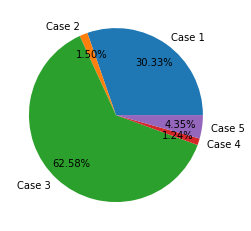

(<Figure size 432x288 with 1 Axes>, <Axes: >)

In [37]:
# def pie_chart(sizes,
#               labels,
#               fig=None,
#               ax=None,
#               pct_distance=0.75,
#               label_distance=1.1,
#               relative=True,
#               colors=None,
#               save_path=None,
#               show=True):
#     if fig is None or ax is None:
#         plt.clf()
#         fig, ax = plt.subplots()
#     if relative:
#         autopct = '%1.2f%%'
        
#     # Check lengths of data passed in
#     assert len(sizes) == len(labels), "Received {} length array for sizes and {} length array for labels".format(
#         len(sizes), len(labels))
#     if colors is not None:
#         assert len(sizes) == len(colors), "Received invalid length array for colors ({}). Expected {}.".format(
#             len(colors), len(sizes))
#     # Plot pie chart
#     ax.pie(
#         sizes,
#         labels=labels,
#         pctdistance=pct_distance,
#         labeldistance=label_distance,
#         autopct=autopct,
#         colors=colors)
    
#     if save_path is not None:
#         plt.savefig(save_path)
    
#     if show:
#         plt.show()
        
#     return fig, ax

pie_chart(
    sizes=total_n_aligned,
    labels=["Case 1", "Case 2", "Case 3", "Case 4", "Case 5"])

## RQ: For each alignment pair, which confusion metric best predicts it?


### Conduct sensitivity of n_bins on Pearson's between confusion and alignment

<Figure size 432x288 with 0 Axes>

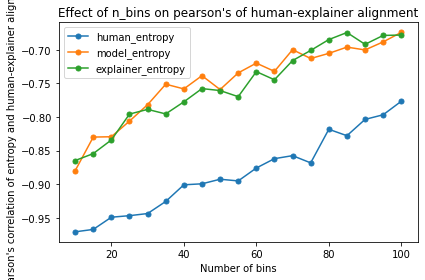

<Figure size 432x288 with 0 Axes>

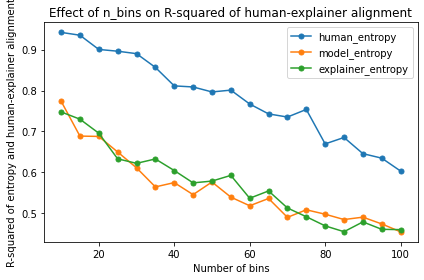

<Figure size 432x288 with 0 Axes>

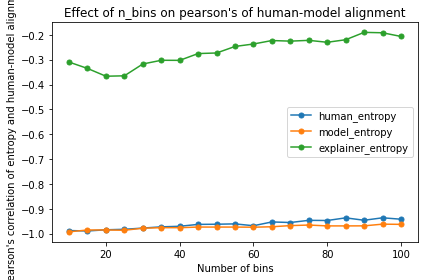

<Figure size 432x288 with 0 Axes>

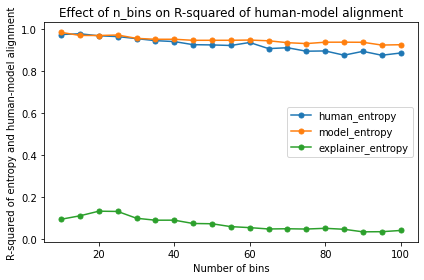

<Figure size 432x288 with 0 Axes>

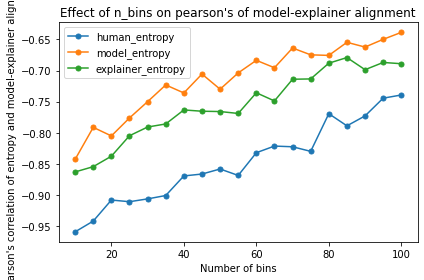

<Figure size 432x288 with 0 Axes>

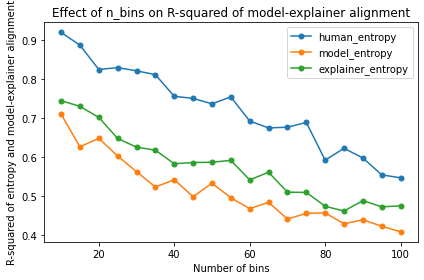

In [12]:
nbins_sensitivity_save_dir = os.path.join(graph_save_dir, 'nbins_sensitivity')
ensure_dir(nbins_sensitivity_save_dir)

agent_pairs = [
        ('human', 'explainer'),
        ('human', 'model'),
        ('model', 'explainer')]
agents = ['human', 'model', 'explainer']
n_bins = [i for i in range(10, 101, 5)]
iv_name_templates = ['{}_entropy', '{}_t2c']
# iv_name_templates = ['{}_t2c', '{}_entropy']
# iv_name_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']

for pair_idx, pair in enumerate(agent_pairs):
    agent1, agent2 = pair
    all_pearsons = []
    all_r_squared = []

    for iv_agent in agents:
        iv_names = [template.format(iv_agent) for template in iv_name_templates]
        
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
                df=df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreements, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
            pearsons = stats.pearsonr(iv_means, cur_agreements).statistic
            cur_pearsons.append(pearsons)

            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_pearsons,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="Pearson's correlation of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on pearson\'s of {}-{} alignment'.format(
            agent1, agent2),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_pearsons_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_r_squared,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="R-squared of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on R-squared of {}-{} alignment'.format(agent1, agent2),
        show=True,
        save_path=os.path.join(nbins_sensitivity_save_dir, 'nbins_rsquared_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))

### Linear Regression between confusion metrics and alignment

Figure saved to saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/graphs/iv_confusion_dv_alignment/human-explainer_alignment_v_t2c.png


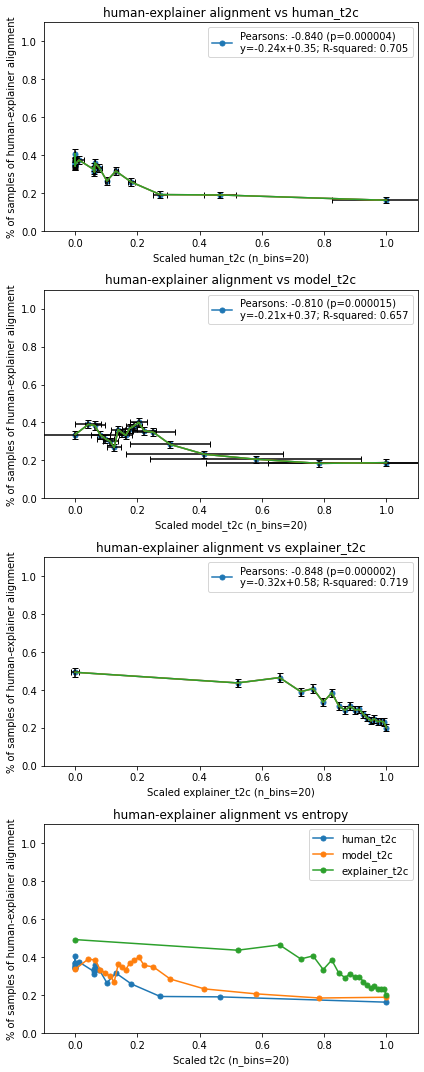

Figure saved to saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/graphs/iv_confusion_dv_alignment/human-model_alignment_v_t2c.png


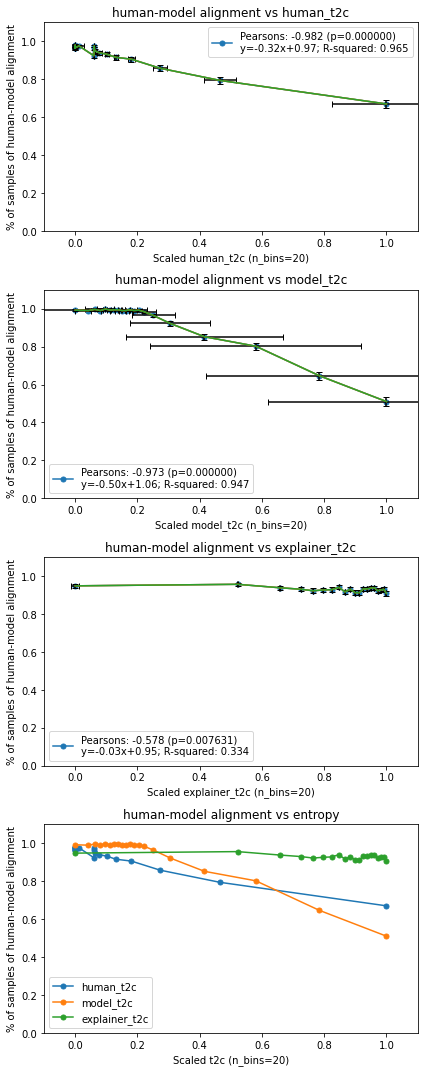

Figure saved to saved/cifar10/resnet18/explainer/sift_descriptor_histogram/cifar32_32_sigma1.6/dense_stride_2/minibatch_kmeans/500means/model_soft_labels/0606_125216/analysis/graphs/iv_confusion_dv_alignment/model-explainer_alignment_v_t2c.png


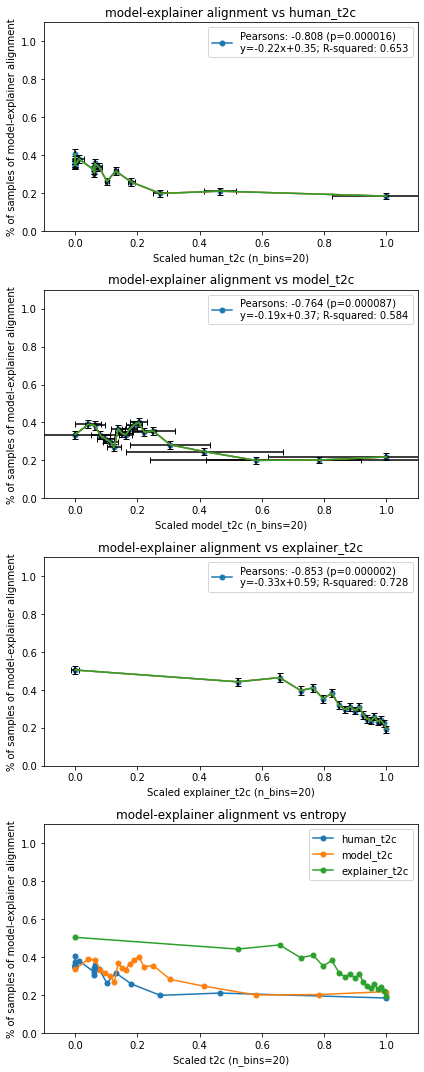

Pearsons between variance of confusion and variance of alignment: 0.063 (p=0.399525)
y=0.00x+0.02; R-squared: 0.004


In [42]:
linear_reg_save_dir = os.path.join(graph_save_dir, 'iv_confusion_dv_alignment')
ensure_dir(linear_reg_save_dir)

agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
agents = ['human', 'model', 'explainer']

plot_xerr = True
plot_yerr = True

# confusion_templates = ['{}_entropy', '{}_t2c']
confusion_templates = ['{}_t2c', '{}_entropy']
# confusion_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']
x_variance = []
y_variance = []
if 'entropy' in confusion_templates[0]:
    n_bins = 15
elif 't2c' in confusion_templates[0]:
    n_bins = 20
elif 'top_confidence' in confusion_templates[0]:
    n_bins = 25
else:
    raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    ylabel = '% of samples of {}-{} alignment'.format(agent1, agent2)
    # Separate plot for confusion from each agent
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        xlabel = 'Scaled {} (n_bins={})'.format(confusion_names[0], n_bins)
        bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
            df=df,
            sort_columns=confusion_names, 
            n_bins=n_bins)
        min_iv = np.amin(iv_means)
        max_iv = np.amax(iv_means)
        iv_means = (iv_means - min_iv) / (max_iv - min_iv)
        
        cur_agreement, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
        confusions.append(iv_means)
        agreements.append(cur_agreement)
        
        pearsons = stats.pearsonr(
            x=iv_means,
            y=cur_agreement)
        slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
        r_squared = r ** 2
        fig, ax = plot(
            xs=[iv_means],
            ys=[cur_agreement],
            fig=fig,
            ax=axs[idx],
            xlabel=xlabel,
            ylabel=ylabel,
            ylimits=[0, 1.1],
            xlimits=[-0.1, 1.1],
            labels=['Pearsons: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
                pearsons.statistic, pearsons.pvalue, slope, yint, r_squared)],
            title='{}-{} alignment vs {}'.format(agent1, agent2, confusion_names[0]),
            show=False)
        
        if plot_xerr:
            ax.errorbar(
                x=iv_means,
                y=cur_agreement,
                xerr=iv_stds,
                ecolor='black',
                capsize=3.0)
        if plot_yerr:
            ax.errorbar(
                x=iv_means,
                y=cur_agreement,
                yerr=agreement_ses,
                ecolor='black',
                capsize=3.0)
        x_variance.append(iv_stds)
        y_variance.append(agreement_ses)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1.1],
        xlimits=[-0.1, 1.1],
        title=title,
        show=False)
    axs[-1] = ax
    save_path = os.path.join(linear_reg_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1]))
    plt.savefig(save_path)
    print("Figure saved to {}".format(save_path))
    plt.show()
    
x_variance = np.concatenate(x_variance, axis=0)
y_variance = np.concatenate(y_variance, axis=0)

slope, yint, r, p, std_err = stats.linregress(
    x=x_variance,
    y=y_variance)
print('Pearsons between variance of confusion and variance of alignment: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
        r, p, slope, yint, r**2))


### Logistic Regression Trials

In [6]:
# Set constants
seed = 0
penalty = 'l2'
solver = 'liblinear'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver
}

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
train_rows = df.sample(frac=train_split, random_state=seed)
val_rows = df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
agent_pairs = [
    ('human', 'explainer'),
    ('model', 'explainer'),
    ('human', 'model')]

# x_names = ['{}_{}'.format(agent, confusion_type) for agent in agents]
agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]

In [7]:
# List to store results from all trials
trials = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * len(agent_pairs)
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in df.columns 
        
        for agent1, agent2 in agent_pairs:
            # set seed 
            seed = 0
            y_names = ['{}_{}_alignment'.format(agent1, agent2)]
            print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
            cur_data, trial_key = run_feature_importance_trial(
                train_rows=train_rows,
                val_rows=val_rows,
                x_names=x_names,
                y_names=y_names,
                metric_names=metric_names,
                trial_id=trial_idx-1,
                logistic_regression_args=logistic_regression_args,
                seed=seed)

            trials.append(cur_data)
            trial_keys.append(trial_key)
            trial_idx += 1


Itr 1/63: IV: ['human_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[-0.251773]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 2/63: IV: ['human_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[-0.25194439]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 3/63: IV: ['human_top_confidence'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_top_confidence']
Coefficients: [[0.77593448]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 4/63: IV: ['model_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_top_confidence']
Coefficients: [[-0.24876516]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 5/63: IV: ['model_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['model_top_confidence']
Coefficients: [[-0.24827492]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 6/63: IV: ['model_top_confidence'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Best accuracy: 0.9353333333333333 Regularization: 0.05
Learned classifier to predict ['human_model_alignment'] from ['model_top_confidence']
Coefficients: [[3.22330798]]
Itr 7/63: IV: ['explainer_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6886666666666666 Regularization: 0.05
Best accuracy: 0.6896666666666667 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['explainer_top_confidence']
Coefficients: [[1.79837367]]
Itr 8/63: IV: ['explainer_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.685 Regularization: 0.05
Best accuracy: 0.6863333333333334 Regularization: 0.1
Learned classifier to predict ['model_explainer_alignment'] from ['explainer_top_confidence']
Coefficients: [[1.81769671]]
I

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 10/63: IV: ['human_top_confidence', 'explainer_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6886666666666666 Regularization: 0.05
Best accuracy: 0.6903333333333334 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence', 'explainer_top_confidence']
Coefficients: [[0.96183965 1.72087004]]
Itr 11/63: IV: ['human_top_confidence', 'explainer_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.685 Regularization: 0.05
Best accuracy: 0.6866666666666666 Regularization: 0.1
Learned classifier to predict ['model_explainer_alignment'] from ['human_top_confidence', 'explainer_top_confidence']
Coefficients: [[0.79883201 1.75305067]]
Itr 12/63: IV: ['human_top_confidence', 'explainer_top_confidence'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 13/63: IV: ['human_top_confidence', 'model_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence', 'model_top_confidence']
Coefficients: [[-0.18766189 -0.18341071]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 14/63: IV: ['human_top_confidence', 'model_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_top_confidence', 'model_top_confidence']
Coefficients: [[-0.18803163 -0.18276279]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 15/63: IV: ['human_top_confidence', 'model_top_confidence'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_top_confidence', 'model_top_confidence']
Coefficients: [[0.58457418 0.63992125]]
Itr 16/63: IV: ['model_top_confidence', 'explainer_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6886666666666666 Regularization: 0.05
Best accuracy: 0.6903333333333334 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['model_top_confidence', 'explainer_top_confidence']
Coefficients: [[0.77418237 1.72867835]]
Itr 17/63: IV: ['model_top_confidence', 'explainer_top_confidence'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.685 Regularization: 0.05
Best accuracy: 0.6866666666666666 Regularization: 0.1
Learned classifier to predict ['mo

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 23/63: IV: ['human_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_entropy']
Coefficients: [[-0.07954009]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 24/63: IV: ['human_entropy'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_entropy']
Coefficients: [[0.02649776]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 25/63: IV: ['model_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_entropy']
Coefficients: [[-0.09639553]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 26/63: IV: ['model_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['model_entropy']
Coefficients: [[-0.09156286]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 27/63: IV: ['model_entropy'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Best accuracy: 0.9353333333333333 Regularization: 0.05
Learned classifier to predict ['human_model_alignment'] from ['model_entropy']
Coefficients: [[-3.34470723]]
Itr 28/63: IV: ['explainer_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6876666666666666 Regularization: 0.1
Best accuracy: 0.6886666666666666 Regularization: 0.5
Best accuracy: 0.689 Regularization: 1
Best accuracy: 0.6896666666666667 Regularization: 3
Learned classifier to predict ['human_explainer_alignment'] from ['explainer_entropy']
Coefficients: [[-3.34544423]]
Itr 29/63: IV: ['explainer_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.6843333333333333 Regularization: 0.1
Best accuracy: 0.6853333333333333 Regularization: 0.5
Best accuracy: 0.6856666666666666 Regularization: 1


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 31/63: IV: ['human_entropy', 'explainer_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6876666666666666 Regularization: 0.1
Best accuracy: 0.69 Regularization: 0.5
Learned classifier to predict ['human_explainer_alignment'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[-2.48216114 -2.11807037]]
Itr 32/63: IV: ['human_entropy', 'explainer_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.6843333333333333 Regularization: 0.1
Best accuracy: 0.6863333333333334 Regularization: 0.5
Learned classifier to predict ['model_explainer_alignment'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[-2.14159784 -2.10790816]]
Itr 33/63: IV: ['human_entropy', 'explainer_entropy'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_entropy', 'explainer_e

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 34/63: IV: ['human_entropy', 'model_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_entropy', 'model_entropy']
Coefficients: [[-0.08418671 -0.09531326]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 35/63: IV: ['human_entropy', 'model_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_entropy', 'model_entropy']
Coefficients: [[-0.07835466 -0.09055348]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 36/63: IV: ['human_entropy', 'model_entropy'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Best accuracy: 0.9373333333333334 Regularization: 0.1
Learned classifier to predict ['human_model_alignment'] from ['human_entropy', 'model_entropy']
Coefficients: [[-2.11755957 -4.14402712]]
Itr 37/63: IV: ['model_entropy', 'explainer_entropy'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6876666666666666 Regularization: 0.1
Best accuracy: 0.69 Regularization: 0.5
Learned classifier to predict ['human_explainer_alignment'] from ['model_entropy', 'explainer_entropy']
Coefficients: [[-1.87783558 -2.08320722]]
Itr 38/63: IV: ['model_entropy', 'explainer_entropy'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.6843333333333333 Regularization: 0.1
Best accuracy: 0.6866666666666666 Regularization: 0.5
Learned classifier to predict ['model_explainer_a

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 44/63: IV: ['human_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_t2c']
Coefficients: [[-0.08526678]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 45/63: IV: ['human_t2c'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_t2c']
Coefficients: [[0.00769811]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 46/63: IV: ['model_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_t2c']
Coefficients: [[-0.19769635]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 47/63: IV: ['model_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['model_t2c']
Coefficients: [[-0.18945929]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 48/63: IV: ['model_t2c'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['model_t2c']
Coefficients: [[0.14758699]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 49/63: IV: ['explainer_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6873333333333334 Regularization: 0.01
Best accuracy: 0.6896666666666667 Regularization: 0.05
Best accuracy: 0.6906666666666667 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['explainer_t2c']
Coefficients: [[-1.65063493]]
Itr 50/63: IV: ['explainer_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.684 Regularization: 0.01
Best accuracy: 0.6873333333333334 Regularization: 0.05
Learned classifier to predict ['model_explainer_alignment'] from ['explainer_t2c']
Coefficients: [[-1.24601142]]
Itr 51/63: IV: ['explainer_t2c'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['explainer_t2c']
Coefficients: [[0.72518395]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 52/63: IV: ['human_t2c', 'explainer_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.6873333333333334 Regularization: 0.01
Best accuracy: 0.69 Regularization: 0.05
Best accuracy: 0.6903333333333334 Regularization: 0.5
Learned classifier to predict ['human_explainer_alignment'] from ['human_t2c', 'explainer_t2c']
Coefficients: [[-1.94074681 -2.53843757]]
Itr 53/63: IV: ['human_t2c', 'explainer_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.684 Regularization: 0.01
Best accuracy: 0.688 Regularization: 0.05
Learned classifier to predict ['model_explainer_alignment'] from ['human_t2c', 'explainer_t2c']
Coefficients: [[-0.96762609 -1.20580605]]
Itr 54/63: IV: ['human_t2c', 'explainer_t2c'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Learned classifier to predict ['human_model_alignment'] from ['human_t2c', 'explainer_t2c']
Coeffic

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Itr 55/63: IV: ['human_t2c', 'model_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['human_t2c', 'model_t2c']
Coefficients: [[-0.08743549 -0.19531591]]


/n/fs/ac-alignment/explain-alignment/src/model/metric.py:175: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Itr 56/63: IV: ['human_t2c', 'model_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Learned classifier to predict ['model_explainer_alignment'] from ['human_t2c', 'model_t2c']
Coefficients: [[-0.07968487 -0.18728401]]


/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-project/anaconda3/envs/model-correlation/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/n/fs/ac-p

Itr 57/63: IV: ['human_t2c', 'model_t2c'] DV: ['human_model_alignment']
Best accuracy: 0.9343333333333333 Regularization: 0.001
Best accuracy: 0.9363333333333334 Regularization: 0.1
Learned classifier to predict ['human_model_alignment'] from ['human_t2c', 'model_t2c']
Coefficients: [[-1.77535833 -3.80919381]]
Itr 58/63: IV: ['model_t2c', 'explainer_t2c'] DV: ['human_explainer_alignment']
Best accuracy: 0.687 Regularization: 0.001
Best accuracy: 0.691 Regularization: 0.05
Best accuracy: 0.6916666666666667 Regularization: 0.5
Learned classifier to predict ['human_explainer_alignment'] from ['model_t2c', 'explainer_t2c']
Coefficients: [[-1.17102476 -2.43838857]]
Itr 59/63: IV: ['model_t2c', 'explainer_t2c'] DV: ['model_explainer_alignment']
Best accuracy: 0.6836666666666666 Regularization: 0.001
Best accuracy: 0.684 Regularization: 0.01
Best accuracy: 0.6873333333333334 Regularization: 0.05
Best accuracy: 0.688 Regularization: 0.1
Learned classifier to predict ['model_explainer_alignment